# Investigate which Architecture is Optimal for the Dataset
Examining the number of layers, number of nodes per layer and other hyperparameters.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState, MT19937, SeedSequence
import pandas as pd
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

## Constraints
To reduce the number of variables to test, some values will be kept the same:
- `StandardScaler` will be used to scale the data.
- Activation function for hidden layers will be set to `relu`
- Activation function for output layer will be set to `sigmoid`
- Batch size and number of epochs

In [18]:
params = {
    'random_state': 42,
    'num_epochs': 500,
    'batch_size': 32,
}

rs = RandomState(MT19937(SeedSequence(params['random_state'])))

In [19]:
df_heart = pd.read_csv('data/heart_failure_clinical_records_dataset.xls')

In [20]:
df_heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [21]:
X = df_heart.drop(columns='DEATH_EVENT')
y = df_heart['DEATH_EVENT'].to_numpy()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=params['random_state'], stratify=y
)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Define the Model

Helper functions to choose parameters for a model

In [25]:
def select_model_params(param_dist: dict) -> dict:
    return {
        'input_size': np.random.choice(param_dist['input_size']),
        # Probability distribution for num_hidden_layers 
        # to prevent 0 from being chosen too often
        'num_hidden_layers': np.random.choice(param_dist['num_hidden_layers'], p=[0.1, 0.3, 0.3, 0.3]),
        'nodes_layer_1': np.random.choice(param_dist['nodes_layer_1']),
        'nodes_layer_2': np.random.choice(param_dist['nodes_layer_2']),
        'nodes_layer_3': np.random.choice(param_dist['nodes_layer_3']),
        'dropout_rate': np.random.choice(param_dist['dropout_rate']),
        'loss': np.random.choice(param_dist['loss']),
        'optimizer': np.random.choice(param_dist['optimizer']),
        'learning_rate': np.random.choice(param_dist['learning_rate'])
    }


def select_fit_params(param_dist: dict) -> tuple[int, int]:
    return (
        np.random.choice(param_dist['batch_size']),
        np.random.choice(param_dist['epochs']),
    )

Functions to create the model

In [ ]:
def create_model(
    input_size: int = 0,
    num_hidden_layers: int = 0,
    nodes_layer_1: int = 0,
    nodes_layer_2: int = 0,
    nodes_layer_3: int = 0,
    dropout_rate: float = 0,
    loss = None,
    optimizer = None,
    learning_rate: float = 0
) -> tf.keras.models.Sequential:
    
    # create model for KerasClassifier
    structure = np.array([nodes_layer_1, nodes_layer_2, nodes_layer_3])[:num_hidden_layers]
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((input_size,)))                    # input
    add_hidden_layers(model, structure, dropout_rate=dropout_rate)  # hidden
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))       # output
    
    optimizer._set_hyper('learning_rate', learning_rate)

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
        ]
    )

    return model


def add_hidden_layers(
    model: tf.keras.models.Sequential,
    structure,
    activation: str = 'relu',
    dropout_rate: float = 0.0
):
    for layer in structure:
        model.add(tf.keras.layers.Dense(layer, activation=activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))

## Fit the model

Define early stopping conditions

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, min_delta=1e-6, patience=3
)

Choose hyperparameter distributions

In [27]:
param_dist = {
    'random_state': 42,
    'input_size': [X.columns.size],
    'num_hidden_layers': np.arange(0, 3 + 1, step=1),
    'nodes_layer_1': np.arange(3, 24, step=3),
    'nodes_layer_2': np.arange(3, 24, step=3),
    'nodes_layer_3': np.arange(3, 24, step=3),
    'dropout_rate': np.linspace(0.0, 0.6, num=6),
    'loss': [tf.keras.losses.BinaryCrossentropy()],
    'optimizer': [tf.keras.optimizers.SGD(), tf.keras.optimizers.Adam()],
    'learning_rate': np.logspace(-3, -1, num=10),
    'epochs': [100, 250, 500],
    'batch_size': [16, 32, 64],
}

Random Search & Cross Validate Models to Find the Best One

In [28]:
histories = []

# Select parameters to use for random search
model_params = select_model_params(param_dist)
batch_size, epochs = select_fit_params(param_dist)

# use StratifiedKFold to split the data into training and testing sets
for train_index, val_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=param_dist['random_state']).split(X_train, y_train):
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]

    # Clear old models to free up memory
    tf.keras.backend.clear_session()

    model = create_model(**model_params)

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold, validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        use_multiprocessing=True,
        workers=-1
    )

    # Save the model history
    histories.append(history)

Epoch 1/250


6/6 [==============================] - 1s 82ms/step - loss: 0.9883 - accuracy: 0.5866 - precision: 0.2571 - recall: 0.1579 - auc: 0.4878 - val_loss: 0.7325 - val_accuracy: 0.3778 - val_precision: 0.2903 - val_recall: 0.6000 - val_auc: 0.5022
Epoch 2/250
6/6 [==============================] - 0s 7ms/step - loss: 0.8247 - accuracy: 0.5866 - precision: 0.2821 - recall: 0.1930 - auc: 0.5227 - val_loss: 0.6873 - val_accuracy: 0.5778 - val_precision: 0.3889 - val_recall: 0.4667 - val_auc: 0.5533
Epoch 3/250
6/6 [==============================] - 0s 7ms/step - loss: 0.7940 - accuracy: 0.5810 - precision: 0.1538 - recall: 0.0702 - auc: 0.4775 - val_loss: 0.6615 - val_accuracy: 0.6444 - val_precision: 0.4615 - val_recall: 0.4000 - val_auc: 0.6078
Epoch 4/250
6/6 [==============================] - 0s 7ms/step - loss: 0.8157 - accuracy: 0.6145 - precision: 0.2500 - recall: 0.1053 - auc: 0.4886 - val_loss: 0.6468 - val_accuracy: 0.6444 - val_precision: 0.4000 - val_recall: 0.1333 - val_auc: 0.6356

In [33]:
history = histories[0].history

## Plot the Results

In [34]:
def plot_epochs(history: dict, variable: str):
    plt.plot(history[variable])
    plt.plot(history['val_' + variable])
    plt.title(f'Model {variable.capitalize()} Across Training Epochs')
    plt.ylabel(variable.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

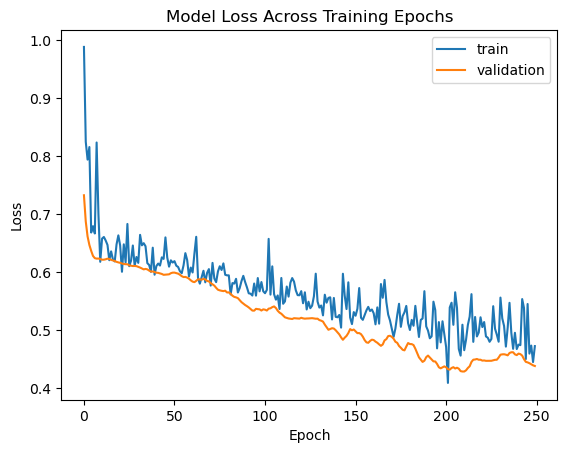

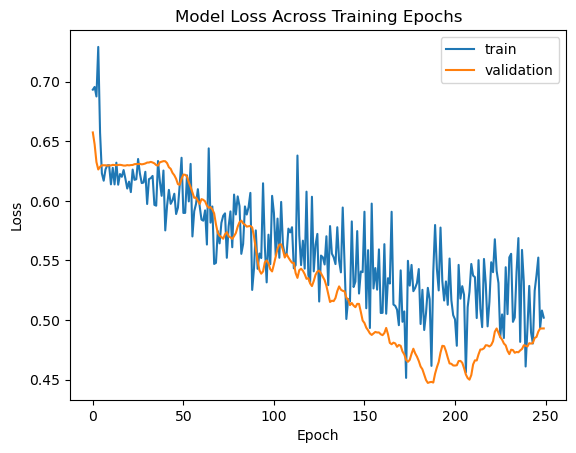

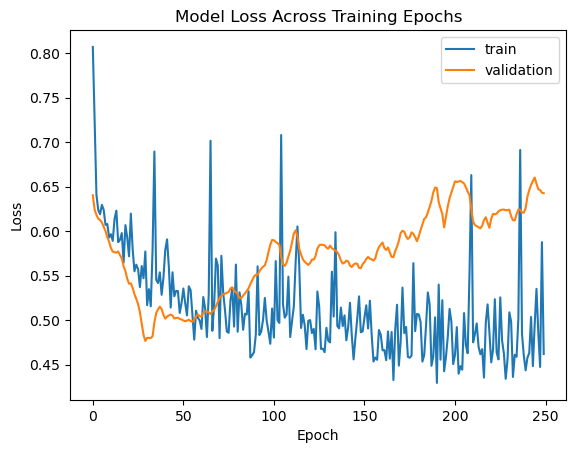

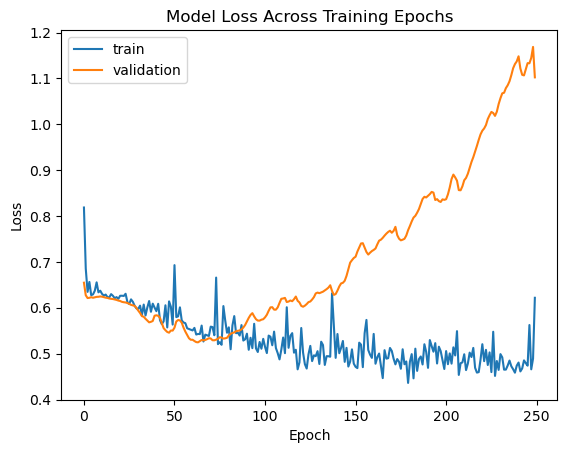

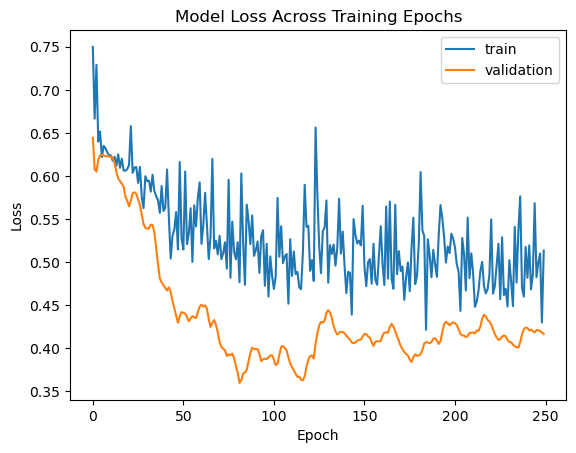

In [36]:
for something in histories:
    plot_epochs(something.history, 'loss')

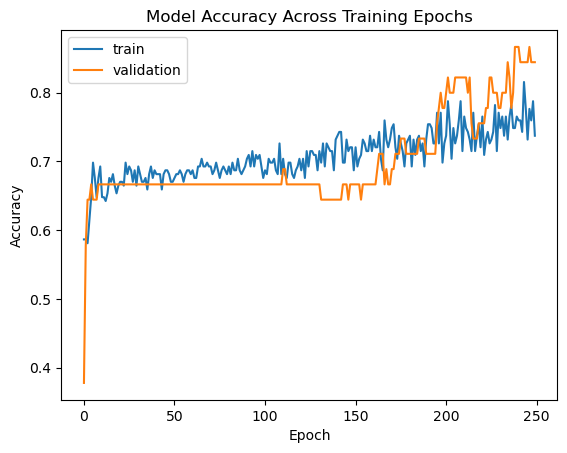

In [37]:
plot_epochs(history, 'accuracy')

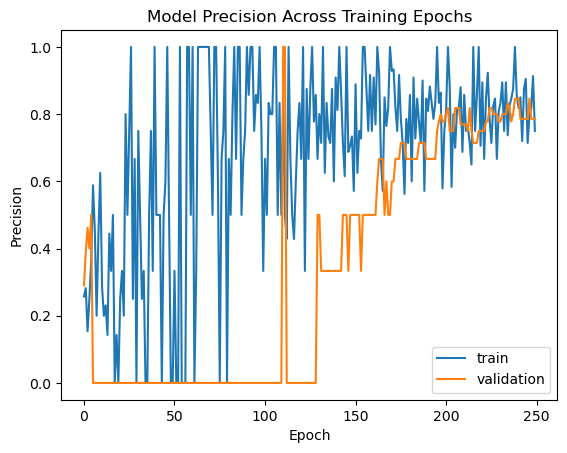

In [38]:
plot_epochs(history, 'precision')

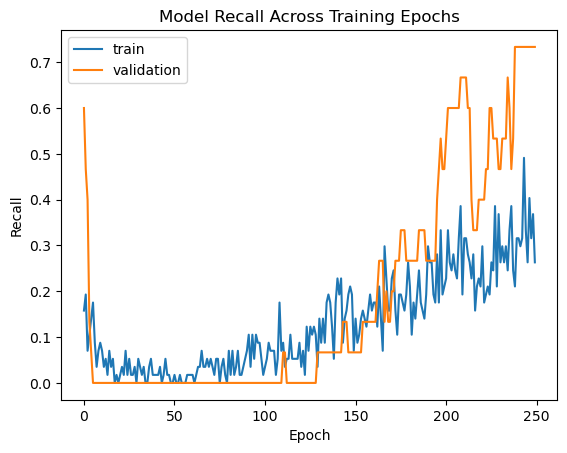

In [39]:
plot_epochs(history, 'recall')

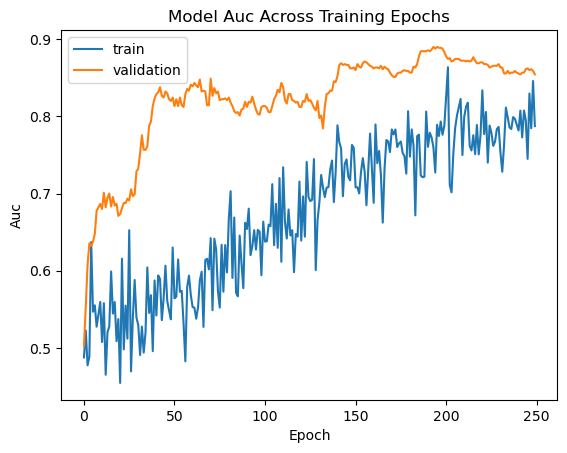

In [40]:
plot_epochs(history, 'auc')

## Track Parameters